### Import libraries

In [66]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent, show
import earthpy as et
import earthpy.plot as ep
import numpy as np
import ogr
from skimage import exposure
from skimage.segmentation import quickshift, slic
from osgeo import gdal
import time
from osgeo import gdal
import cv2
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries



In [2]:
driverTiff = gdal.GetDriverByName('GTiff')

### Import satellite imagery

In [3]:
# Path to the satellite image file
sat_clipped = "Data/imagery_subset_cliped.tif"
dsm_clipped = "Data/DSM_cliped.tif"

In [7]:
sat_src = rio.open(sat_clipped)

r = sat_src.read(1)
g = sat_src.read(2)
b = sat_src.read(3)
nir = sat_src.read(4)

dsm_src = rio.open(dsm_clipped)
dsm = dsm_src.read(1)



In [5]:
# Path to the satellite image file
sat_clipped = "Data/imagery_subset_cliped.tif"
dsm_clipped = "Data/DSM_cliped.tif"
sat_src = rio.open(sat_clipped)

# Read the bands from the satellite image
r = sat_src.read(1)
g = sat_src.read(2)
b = sat_src.read(3)
nir = sat_src.read(4)

# Read the DSM (Digital Surface Model)
dsm_src = rio.open(dsm_clipped)
dsm = dsm_src.read(1)

# Stack all the bands and the DSM into a single array
stacked = np.stack([r, g, b, nir, dsm], axis=-1)

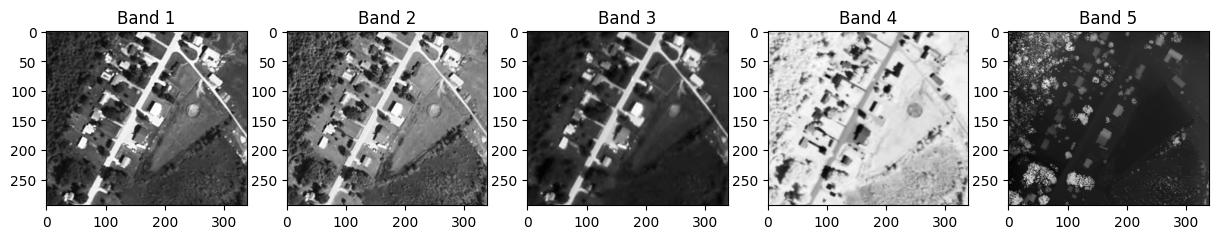

In [6]:

# Visualize each band separately
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed

# Plot each band
for i in range(stacked.shape[-1]):
    plt.subplot(1, stacked.shape[-1], i + 1)
    plt.imshow(stacked[:, :, i], cmap='gray')
    plt.title(f'Band {i+1}')

plt.show()


In [104]:
# scale image values from 0.0 - 1.0
#img = exposure.rescale_intensity(stacked)

# do segmentation multiple options with quickshift
seg_start = time.time()

#PARAMETERS:
#ratio: higher value for ratio allows more weight on the color similarity, while a lower value gives more importance to the spatial proximity
#max_dist: scale

segments = quickshift(stacked, ratio=0.2, max_dist=6.5, convert2lab=False)


print('segments complete', time.time() - seg_start)

# save segments to raster
segments_fn = 'Outputs/segments.tif'
segments_ds = driverTiff.Create(segments_fn, sat_src.width, sat_src.height, 1, gdal.GDT_Float32)
geotransform = sat_src.transform.to_gdal()
segments_ds.SetGeoTransform(geotransform)
segments_ds.SetProjection(sat_src.crs.wkt)
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

segments complete 2.840705156326294


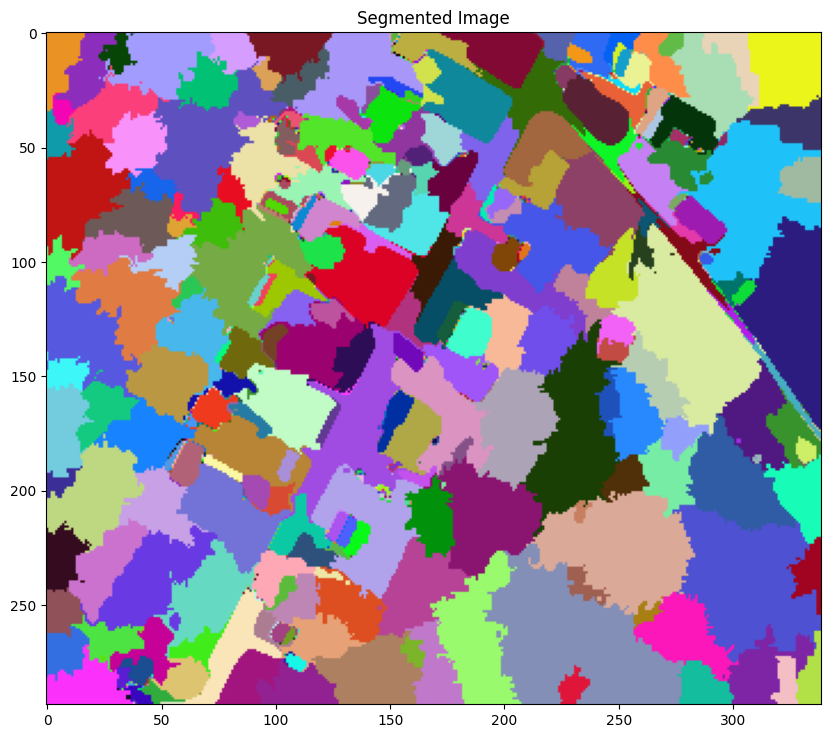

In [105]:
# Read the segmented image
with rio.open(segments_fn) as src:
    segments = src.read(1)

# Get the unique segment IDs
unique_segments = np.unique(segments)

# Create a random colormap for visualization
np.random.seed(42)  # For reproducibility of colors
colors = np.random.randint(0, 255, size=(len(unique_segments), 3), dtype=np.uint8)

# Create a colormap dictionary mapping segment IDs to colors
colormap = {segment_id: color for segment_id, color in zip(unique_segments, colors)}

# Map the segment IDs to the colormap to get the colored segmented image
colored_segments = np.array([colormap[segment_id] for segment_id in segments.flat]).reshape(segments.shape + (3,))

# Display the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(colored_segments)
plt.title('Segmented Image')
plt.show()